In [109]:
#import torch modules
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

#import for plotting results
from matplotlib import pyplot as plt

import dlc_practical_prologue as prologue

from helpers import *

import importlib
import models
importlib.reload(models)
from models import *

In [2]:
def train(model, input_, target_, target_classes, epochs, mini_batch, lr, norm_weight, aux_weight):
    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.Adam(model.parameters(), lr = lr)
    
    losses = []
    for epoch in range(epochs):
        for batch in range(0, input_.size(0), mini_batch):
            train_in = input_.narrow(0, batch, mini_batch)
            target_in = target_.narrow(0, batch, mini_batch)
            target_in_classes = target_classes.narrow(0, batch, mini_batch)
            
            out, out_aux = model(train_in)
            
            loss = criterion(out, target_in)
            for parameter in model.parameters():
                loss += norm_weight * parameter.pow(2).sum()
                
            if out_aux:
                loss += aux_weight*criterion(out_aux[0], target_in_classes[:,0])
                loss += aux_weight*criterion(out_aux[1], target_in_classes[:,1])
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())
            
    return losses

In [3]:
def get_test_error_rate(model, test_input, test_target):
    preds,_ = model(test_input)
    preds = functional.softmax(preds, dim = 0)

    n_errs = 0
    nb_samples = test_input.size(0)
    for i in range(nb_samples):
        if torch.max(preds[i], 0)[1] != test_target[i]:
            n_errs += 1

    return n_errs/nb_samples

In [91]:
#cross-validation
#generate datasets
n_samples = 1000
mini_batch = 100
lr = 0.001
n_CV = 5

data_CV = []
for i in range(n_CV):
    train_data = {}
    valid_data = {}
    train_data["input"], train_data["target"], train_data["classes"], valid_data["input"], valid_data["target"], valid_data["classes"] = prologue.generate_pair_sets(n_samples)
    train_data["input"] = normalize(train_data["input"])
    valid_data["input"] = normalize(valid_data["input"])
    data_CV.append((train_data, valid_data))

In [170]:
#cross-validation
#run grid search
lr = 0.01
model = CNN_base()

norm_weights = [0.01, 0.02, 0.05, 0.1]
#aux_weights = [0.5, 0.75, 1, 1.25, 1.5]
aux_weights = [0]

score_per_model = []
for norm_weight in norm_weights:
    for aux_weight in aux_weights:
        print("norm_weight: {0}, aux_weight: {1}".format(norm_weight, aux_weight))
        score_per_round = []
        for i in range(n_CV):
            train_data = data_CV[i][0]
            valid_data = data_CV[i][1]
            train(model, train_data["input"], train_data["target"], train_data["classes"], epochs = 25, mini_batch = mini_batch, lr = lr, norm_weight=norm_weight, aux_weight=aux_weight)
            score_per_round.append(get_test_error_rate(model, valid_data["input"], valid_data["target"]))

        score_tens = torch.Tensor(score_per_round)
        mean = torch.mean(score_tens).item()
        std = torch.std(score_tens).item()
        print(score_tens)
        score_per_model.append({"norm_weight": norm_weight, "aux_weight": aux_weight, "mean": mean, "std": std})
            

norm_weight: 0.01, aux_weight: 0
tensor([0.2410, 0.2210, 0.2270, 0.2040, 0.2000])
norm_weight: 0.02, aux_weight: 0
tensor([0.2040, 0.1960, 0.2130, 0.1900, 0.2000])
norm_weight: 0.05, aux_weight: 0
tensor([0.2370, 0.2170, 0.2570, 0.2290, 0.2380])
norm_weight: 0.1, aux_weight: 0
tensor([0.2580, 0.2350, 0.2470, 0.2290, 0.2390])


In [163]:
score_per_model

[{'norm_weight': 0.01,
  'aux_weight': 0,
  'mean': 0.19339999556541443,
  'std': 0.004615193698555231},
 {'norm_weight': 0.02,
  'aux_weight': 0,
  'mean': 0.19380000233650208,
  'std': 0.011009087786078453},
 {'norm_weight': 0.05,
  'aux_weight': 0,
  'mean': 0.19660000503063202,
  'std': 0.01871630549430847},
 {'norm_weight': 0.1,
  'aux_weight': 0,
  'mean': 0.19760000705718994,
  'std': 0.014363150112330914}]

In [171]:
f = open("grid_search_CNN_base2.csv", "w")
f.write("norm_weight,mean,std\n")
for row in score_per_model:
    f.write("{},{},{}\n".format(row["norm_weight"], row["mean"], row["std"]))
f.close()

In [164]:
f = open("grid_search_CNN_WS.csv", "w")
f.write("norm_weight,mean,std\n")
for row in score_per_model:
    f.write("{},{},{}\n".format(row["norm_weight"], row["mean"], row["std"]))
f.close()

In [169]:
f = open("grid_search_CNN_AL2.csv", "w")
f.write("norm_weight,aux_weight,mean,std\n")
for row in score_per_model:
    f.write("{},{},{}\n".format(row["norm_weight"], row["aux_weight"], row["mean"], row["std"]))
f.close()

In [166]:
f = open("grid_search_CNN_WS_AL2.csv", "w")
f.write("norm_weight,aux_weight,mean,std\n")
for row in score_per_model:
    f.write("{},{},{}\n".format(row["norm_weight"], row["aux_weight"], row["mean"], row["std"]))
f.close()

In [6]:
n_samples = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(n_samples)
train_input = normalize(train_input)
test_input = normalize(test_input)

full_train_size = train_input.size(0)
idx = torch.randperm(full_train_size)
k_folds = 5
fold_size = full_train_size//k_folds
for i in range(k_folds):
    valid_set = train_input[idx[i*fold_size:(i+1)*fold_size]] if i < k_folds-1 else train_input[idx[i*fold_size:]]

In [172]:
n_samples=1000
n_rounds=15
mini_batch=100
lr = 0.01

#choose models
model_classes = [CNN_base, CNN_AL, CNN_WS, CNN_WS_AL]

#hyperparameters
norm_weights = [0.02, 0.02, 0.01, 0.01]
aux_weights = [0, 1.25, 0, 1.25]

test_accuracy = torch.empty((4, n_rounds))

for i in range(n_rounds):
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(n_samples)
    train_input = normalize(train_input)
    test_input = normalize(test_input)

    for j, model_class in enumerate(model_classes):
        model = model_class()
        train(model, train_input, train_target, train_classes, epochs = 25, mini_batch = mini_batch, lr=lr, norm_weight=norm_weights[j], aux_weight=aux_weights[j])

        acc_round = 1-get_test_error_rate(model, test_input, test_target)
        test_accuracy[j][i] = acc_round

    print('Round ' + str(i+1))
    print('Test accuracy:\n')
    print('CNN_base: {}'.format(test_accuracy[0][i]))
    print('CNN_AL: {}'.format(test_accuracy[1][i]))
    print('CNN_WS: {}'.format(test_accuracy[2][i]))
    print('CNN_WS_AL: {}'.format(test_accuracy[3][i]))

    print('***************************************************************')

Round 1
Test accuracy:

CNN_base: 0.8140000104904175
CNN_AL: 0.859000027179718
CNN_WS: 0.8159999847412109
CNN_WS_AL: 0.8939999938011169
***************************************************************
Round 2
Test accuracy:

CNN_base: 0.7580000162124634
CNN_AL: 0.8510000109672546
CNN_WS: 0.777999997138977
CNN_WS_AL: 0.9110000133514404
***************************************************************
Round 3
Test accuracy:

CNN_base: 0.8059999942779541
CNN_AL: 0.8339999914169312
CNN_WS: 0.8090000152587891
CNN_WS_AL: 0.8989999890327454
***************************************************************
Round 4
Test accuracy:

CNN_base: 0.8130000233650208
CNN_AL: 0.8510000109672546
CNN_WS: 0.8270000219345093
CNN_WS_AL: 0.8899999856948853
***************************************************************
Round 5
Test accuracy:

CNN_base: 0.7599999904632568
CNN_AL: 0.8299999833106995
CNN_WS: 0.8209999799728394
CNN_WS_AL: 0.8920000195503235
*************************************************************

In [173]:
#compute means and standard deviations accross rounds
acc_means = []
acc_stds = []
for i in range(4):
    acc_means.append(test_accuracy[i].mean().item())
    acc_stds.append(test_accuracy[i].std().item())

In [174]:
#CNN_base
print('CNN without weight sharing and without auxiliary loss')
"mean of test scores: {}, std of test scores: {}".format(acc_means[0], acc_stds[0])

CNN without weight sharing and without auxiliary loss


'mean of test scores: 0.7872666716575623, std of test scores: 0.017334802076220512'

In [175]:
#CNN_AL
print('CNN without weight sharing and with auxiliary loss')
"mean of test scores: {}, std of test scores: {}".format(acc_means[1], acc_stds[1])

CNN without weight sharing and with auxiliary loss


'mean of test scores: 0.8489334583282471, std of test scores: 0.01178660523146391'

In [176]:
#CNN_WS
print('CNN with weight sharing and without auxiliary loss')
"mean of test scores: {}, std of test scores: {}".format(acc_means[2], acc_stds[2])

CNN with weight sharing and without auxiliary loss


'mean of test scores: 0.8082000613212585, std of test scores: 0.012935000471770763'

In [177]:
#CNN_WS_AL
print('CNN with weight sharing and with auxiliary loss')
"mean of test scores: {}, std of test scores: {}".format(acc_means[3], acc_stds[3])

CNN with weight sharing and with auxiliary loss


'mean of test scores: 0.902400016784668, std of test scores: 0.012368163093924522'

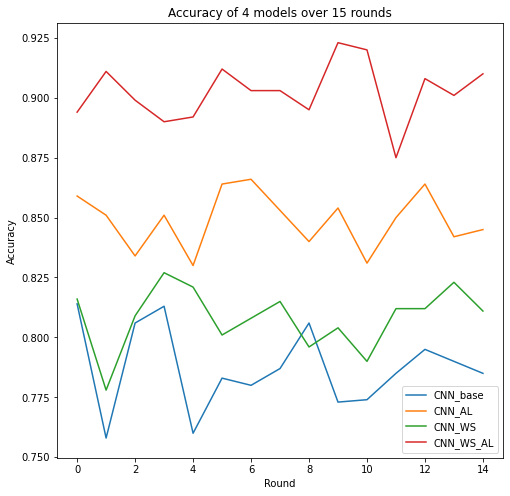

In [178]:
#plot results for each round
plt.figure(figsize=(8, 8))
ax = plt.axes()
ax.plot(test_accuracy[0], label='CNN_base')
ax.plot(test_accuracy[1], label='CNN_AL')
ax.plot(test_accuracy[2], label='CNN_WS')
ax.plot(test_accuracy[3], label='CNN_WS_AL')
ax.legend()
plt.title('Accuracy of 4 models over {} rounds'.format(n_rounds))
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.show()

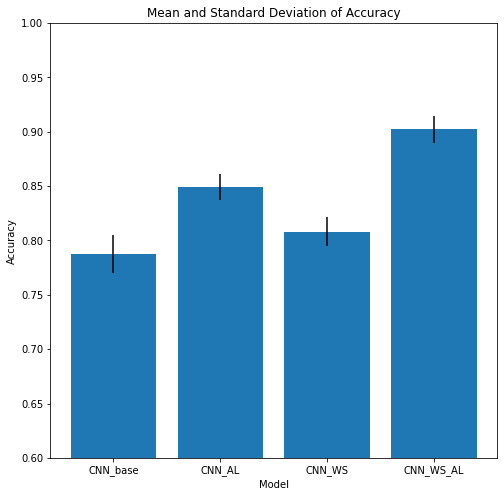

In [179]:
#plot mean and std of accuracy
plt.figure(figsize=(8, 8))
plt.bar(["CNN_base", "CNN_AL", "CNN_WS", "CNN_WS_AL"], acc_means, yerr=acc_stds)
plt.ylim([0.6, 1])
plt.title('Mean and Standard Deviation of Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()